# 2.1 Feature Engineering


**Objetivo:** Criar e transformar features para melhorar o desempenho dos modelos

## Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Carregamento dos Dados Limpos

In [2]:
data_path = Path('../data/interim/Cardiovascular_Disease_Dataset_Clean.csv')
df = pd.read_csv(data_path, sep = ";")

print(f"Dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
df.head()

Dataset: 947 linhas x 14 colunas


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,119250,40,1,0,94,229.0,0,1,115,0,3.7,1,1,0
1,119372,49,1,2,133,142.0,0,0,202,1,5.0,1,0,0
2,132514,43,1,0,138,295.0,1,1,153,0,3.2,2,2,1
3,168686,79,1,2,130,240.0,0,2,157,0,2.5,2,1,1
4,170498,52,1,0,127,345.0,0,0,192,1,4.9,1,0,0


## Criação de Novas Features

Com o objetivo de aprimorar a capacidade preditiva do modelo, baseamo-nos em literatura médica especializada para realizar a engenharia de atributos. Identificamos que faixas específicas de valores numéricos apresentam comportamentos clínicos similares quanto ao risco cardiovascular.

Dessa forma, realizamos a categorização (discretização) de três variáveis principais em grupos de risco (0, 1 e 2):

* **Idade (`age_group`):** Segmentada em **Jovens** (até 40 anos), **Meia-idade** (40 a 60 anos) e **Idosos** (acima de 60 anos).
* **Colesterol Sérico (`chol_category`):** Classificado conforme diretrizes clínicas em **Normal** (até 200 mg/dL), **Limítrofe** (200 a 240 mg/dL) e **Alto** (acima de 240 mg/dL).
* **Pressão Arterial (`bp_category`):** Dividida em **Normal** (até 120 mmHg), **Elevada** (120 a 160 mmHg) e **Alta** (acima de 160 mmHg).

Além disso, desenvolvemos três novas *features* para capturar interações fisiológicas mais complexas:
1.  **Colesterol ajustado pela idade:** A razão entre o colesterol sérico e a idade do paciente.
2.  **Índice Pressão × Idade:** O produto entre a pressão arterial em repouso e a idade, visando ponderar o impacto da hipertensão ao longo do envelhecimento.
3.  **Reserva Cronotrópica estimada:** Calculada pela razão entre a frequência cardíaca máxima atingida e a frequência máxima teórica (220 - idade).

In [3]:
# Categorizando as features numéricas

# Categorização da idade
df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 40, 60, np.inf],
    labels=[0, 1, 2]  # 0=jovem, 1=meia-idade, 2=idoso
)

# Categorização do colesterol sérico
df['chol_category'] = pd.cut(
    df['serumcholestrol'],
    bins=[0, 200, 240, np.inf],
    labels=[0, 1, 2]  # 0=normal, 1=limítrofe, 2=alto
)

# Categorização da pressão arterial sistólica
df['bp_category'] = pd.cut(
    df['restingBP'],
    bins=[0, 120, 160, np.inf],
    labels=[0, 1, 2]  # 0=normal, 1=elevada, 2=alta
)


# Colesterol ajustado pela idade
df['cholesterol_age_ratio'] = df['serumcholestrol'] / df['age']

# Índice pressão arterial × idade
df['bp_age_index'] = df['restingBP'] * df['age']

# Reserva cronotrópica
df['chronotropic_reserve'] = df['maxheartrate'] / (220 - df['age'])


print("Novas features criadas:")
print("- age_group (int): 0=jovem | 1=meia-idade | 2=idoso")
print("- chol_category (int): 0=normal | 1=limítrofe | 2=alto")
print("- bp_category (int): 0=normal | 1=elevada | 2=alta")
print("- cholesterol_age_ratio (float)")
print("- bp_age_index (float)")
print("- chronotropic_reserve (float)")

print(f"\nDataset após criação de features: {df.shape[0]} linhas x {df.shape[1]} colunas")

df.head(10)

Novas features criadas:
- age_group (int): 0=jovem | 1=meia-idade | 2=idoso
- chol_category (int): 0=normal | 1=limítrofe | 2=alto
- bp_category (int): 0=normal | 1=elevada | 2=alta
- cholesterol_age_ratio (float)
- bp_age_index (float)
- chronotropic_reserve (float)

Dataset após criação de features: 947 linhas x 20 colunas


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,age_group,chol_category,bp_category,cholesterol_age_ratio,bp_age_index,chronotropic_reserve
0,119250,40,1,0,94,229.0,0,1,115,0,3.7,1,1,0,0,1,0,5.725000,3760,0.638889
1,119372,49,1,2,133,142.0,0,0,202,1,5.0,1,0,0,1,0,1,2.897959,6517,1.181287
2,132514,43,1,0,138,295.0,1,1,153,0,3.2,2,2,1,1,2,1,6.860465,5934,0.864407
3,168686,79,1,2,130,240.0,0,2,157,0,2.5,2,1,1,2,1,1,3.037975,10270,1.113475
4,170498,52,1,0,127,345.0,0,0,192,1,4.9,1,0,0,1,2,1,6.634615,6604,1.142857
5,188225,62,1,0,121,357.0,0,1,138,0,2.8,1,0,0,2,2,1,5.758065,7502,0.873418
6,192523,61,0,0,190,181.0,0,1,150,0,2.9,2,0,1,2,0,2,2.967213,11590,0.943396
7,201030,59,0,1,190,529.0,1,1,151,1,3.2,2,2,1,1,2,2,8.966102,11210,0.937888
8,208877,58,1,2,192,409.0,1,0,138,0,2.3,3,1,1,1,2,2,7.051724,11136,0.851852
9,223295,27,1,0,129,135.0,0,1,192,1,1.0,1,0,0,0,0,1,5.000000,3483,0.994819


Realizamos a separação da variável alvo (target) e a divisão dos dados em conjuntos de treino e teste. O objetivo foi evitar o vazamento de dados (data leakage), garantindo que o conjunto de teste não influencie os parâmetros da normalização subsequente.

In [4]:
# Separar features e target
X = df.drop('target', axis=1)
y = df['target']

# Divisão estratificada treino/teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Conjunto de treino: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição do target no treino:")
print(y_train.value_counts(normalize=True))

Conjunto de treino: 662 amostras
Conjunto de teste: 285 amostras

Distribuição do target no treino:
target
1    0.555891
0    0.444109
Name: proportion, dtype: float64


## Divisão Treino/Teste

**IMPORTANTE**

## Seleção de Features para Modelagem

Na seleção de features numéricas, optamos por utilizar a correlação linear simples (mantendo apenas aquelas > 0.1), em detrimento de métodos mais complexos de seleção. Essa decisão fundamentou-se na análise de PCA, que revelou uma separabilidade quase linear dos dados. Simultaneamente, removemos as colunas originais 'age', 'restingBP' e 'serum_cholesterol', substituídas por suas versões categorizadas. Quanto às variáveis categóricas, manteve-se a utilização de todas.

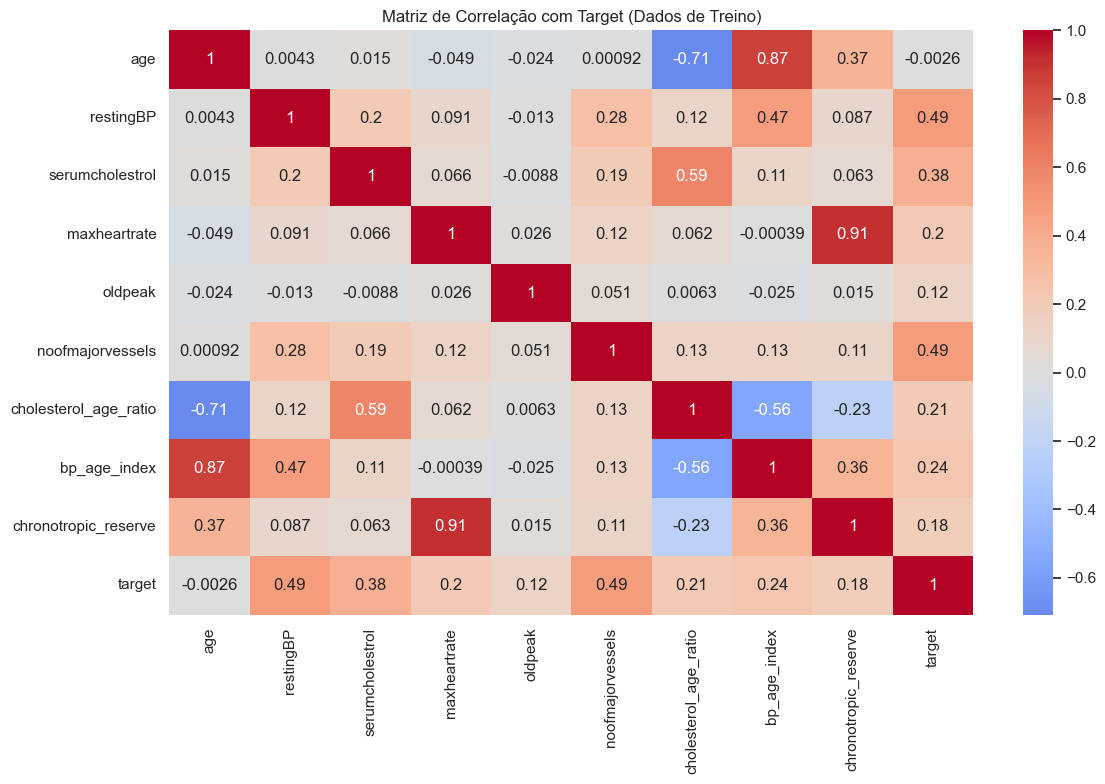

Correlação das features com o target (baseado em treino):
target                   1.000000
noofmajorvessels         0.492916
restingBP                0.486641
serumcholestrol          0.376944
bp_age_index             0.236917
cholesterol_age_ratio    0.210853
maxheartrate             0.201364
chronotropic_reserve     0.182241
oldpeak                  0.120161
age                      0.002565
Name: target, dtype: float64

Features selecionadas por correlação (> 0.1):
['noofmajorvessels', 'bp_age_index', 'cholesterol_age_ratio', 'maxheartrate', 'chronotropic_reserve', 'oldpeak']

Features finais selecionadas: 13
['noofmajorvessels', 'bp_age_index', 'cholesterol_age_ratio', 'maxheartrate', 'chronotropic_reserve', 'oldpeak', 'gender', 'chestpain', 'restingrelectro', 'slope', 'age_group', 'chol_category', 'bp_category']


In [5]:
# Seleção de features baseada em correlação

# Correlação com o target 
numerical_features = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']

# Criar dataframe temporário com treino para análise de correlação
train_data = X_train.copy()
train_data['target'] = y_train

correlation_matrix = train_data[numerical_features + ['target']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação com Target (Dados de Treino)')
plt.tight_layout()
plt.show()

# Features com maior correlação absoluta com target
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
print("Correlação das features com o target (baseado em treino):")
print(target_corr)

# Seleção baseada em threshold de correlação
correlation_threshold = 0.1
selected_features_corr = target_corr[target_corr > correlation_threshold].index.tolist()
selected_features_corr.remove('target') 

# Remover features originais se suas categorizações estiverem presentes
if 'restingBP' in selected_features_corr:
    selected_features_corr.remove('restingBP')
if 'serumcholestrol' in selected_features_corr:
    selected_features_corr.remove('serumcholestrol')
if 'age' in selected_features_corr:
    selected_features_corr.remove('age')    

print(f"\nFeatures selecionadas por correlação (> {correlation_threshold}):")
print(selected_features_corr)

# Features categóricas
categorical_features = ['gender', 'chestpain', 'restingrelectro', 'slope', 'age_group', 'chol_category', 'bp_category']

# Lista final de features selecionadas
selected_features = selected_features_corr + categorical_features
print(f"\nFeatures finais selecionadas: {len(selected_features)}")
print(selected_features)

# Aplicar seleção de features em treino e teste
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## Normalização de Features Numéricas

Realizamos a normalização ajustando o 'scaler' exclusivamente no conjunto de treino, prevenindo assim o vazamento de dados (data leakage). Além disso, o objeto 'scaler' foi salvo para garantir a consistência no pré-processamento de dados futuros.

In [6]:
# Normalização das features numéricas 
numerical_features_to_scale = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']

# Criar e ajustar o scaler APENAS nos dados de treino
scaler = StandardScaler()
scaler.fit(X_train[numerical_features_to_scale])

# Aplicar transformação em treino e teste
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features_to_scale] = scaler.transform(X_train[numerical_features_to_scale])
X_test_scaled[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])

print("Features numéricas normalizadas usando StandardScaler:")
print(numerical_features_to_scale)

print("\nEstatísticas após normalização (Treino):")
print(X_train_scaled[numerical_features_to_scale].describe().round(3))

print("\nEstatísticas após normalização (Teste):")
print(X_test_scaled[numerical_features_to_scale].describe().round(3))

# Aplicar seleção de features após normalização
X_train_final = X_train_scaled[selected_features]
X_test_final = X_test_scaled[selected_features]

print(f"\nShape final - Treino: {X_train_final.shape}")
print(f"Shape final - Teste: {X_test_final.shape}")

Features numéricas normalizadas usando StandardScaler:
['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']

Estatísticas após normalização (Treino):
           age  restingBP  serumcholestrol  maxheartrate  oldpeak  \
count  662.000    662.000          662.000       662.000  662.000   
mean    -0.000      0.000           -0.000         0.000    0.000   
std      1.001      1.001            1.001         1.001    1.001   
min     -1.643     -1.916           -2.136        -2.163   -1.585   
25%     -0.902     -0.777           -0.706        -0.788   -0.825   
50%      0.035     -0.224           -0.014         0.003   -0.181   
75%      0.875      0.990            0.723         0.873    0.740   
max      1.714      1.635            2.417         1.671    2.041   

       noofmajorvessels  cholesterol_age_ratio  bp_age_index  \
count           662.000                662.000       662.000   
m

## Visualização das Features Transformadas

Optamos por visualizar graficamente algumas variáveis para validar o pré-processamento. Verificamos tanto o comportamento das features normalizadas quanto a distribuição das classes nas variáveis categóricas.

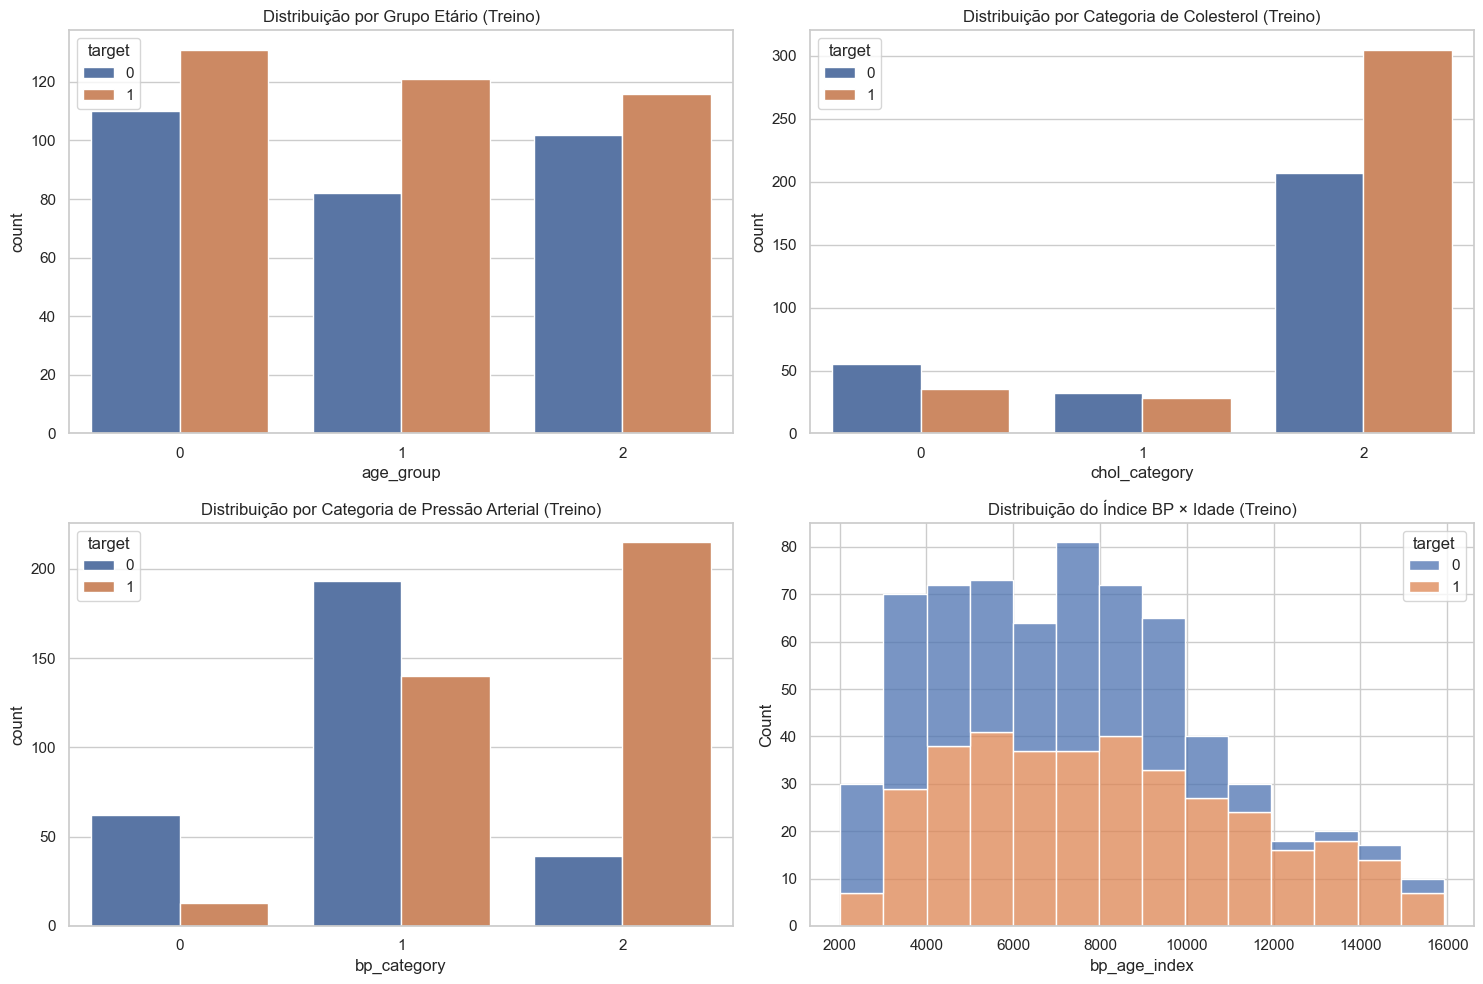

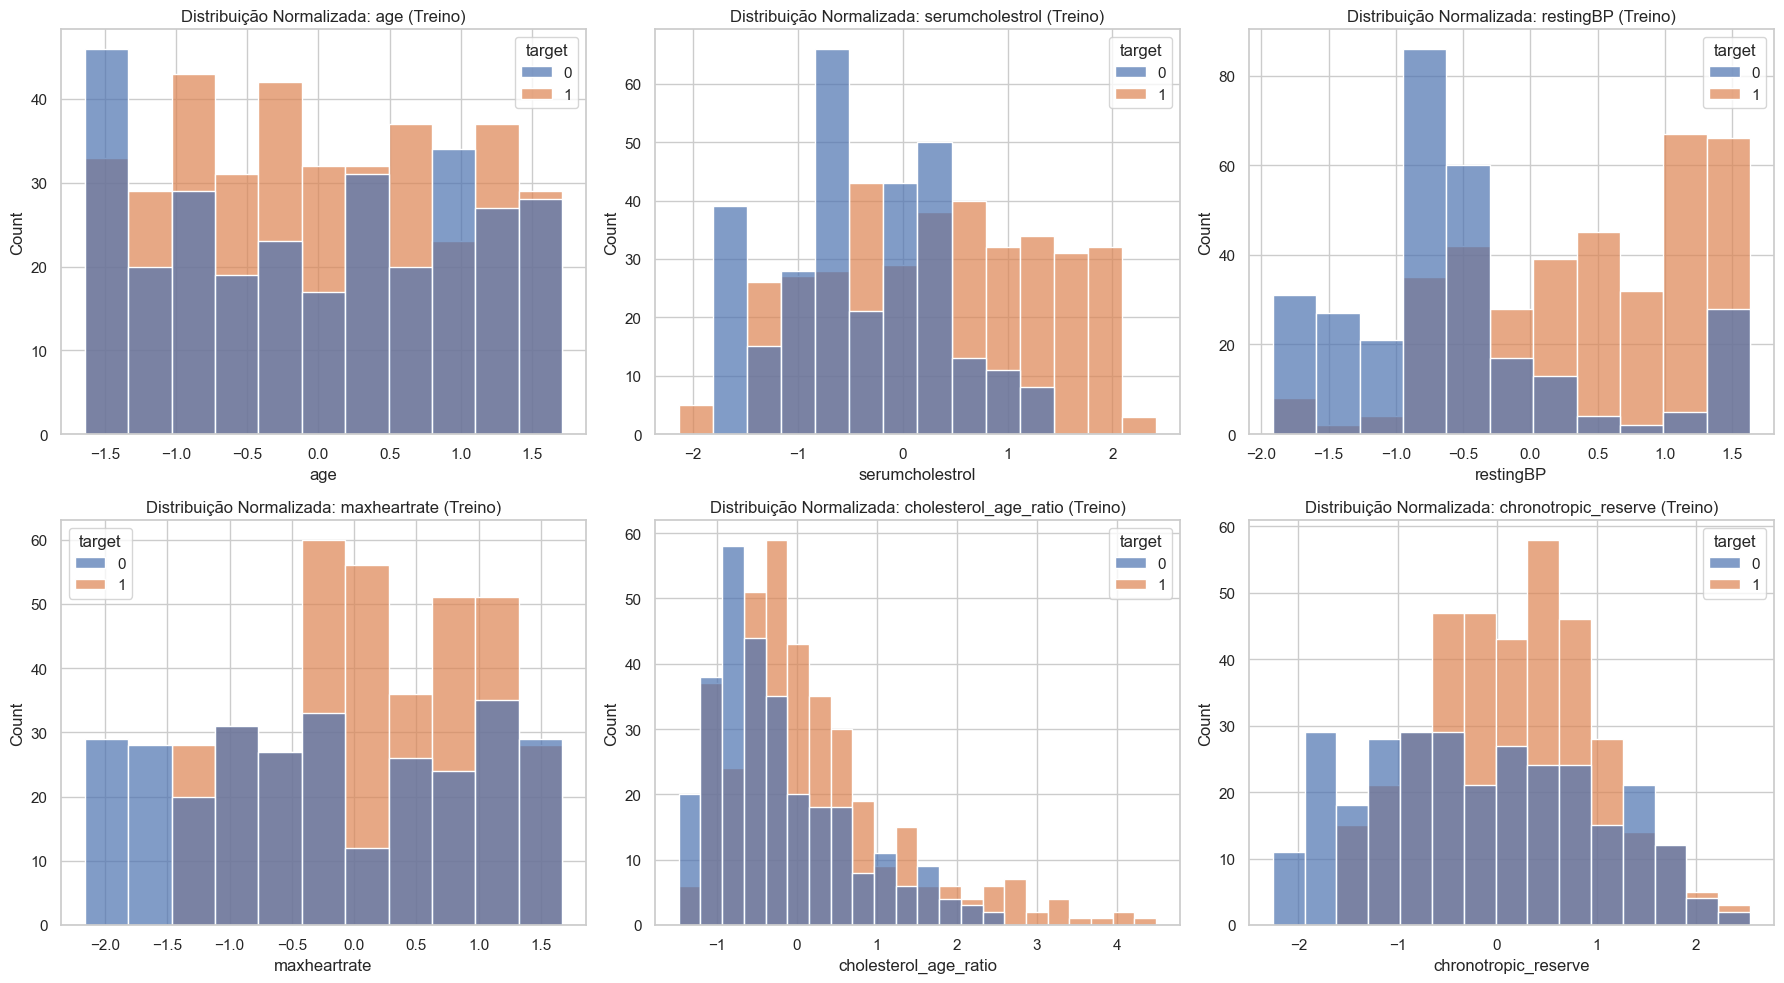

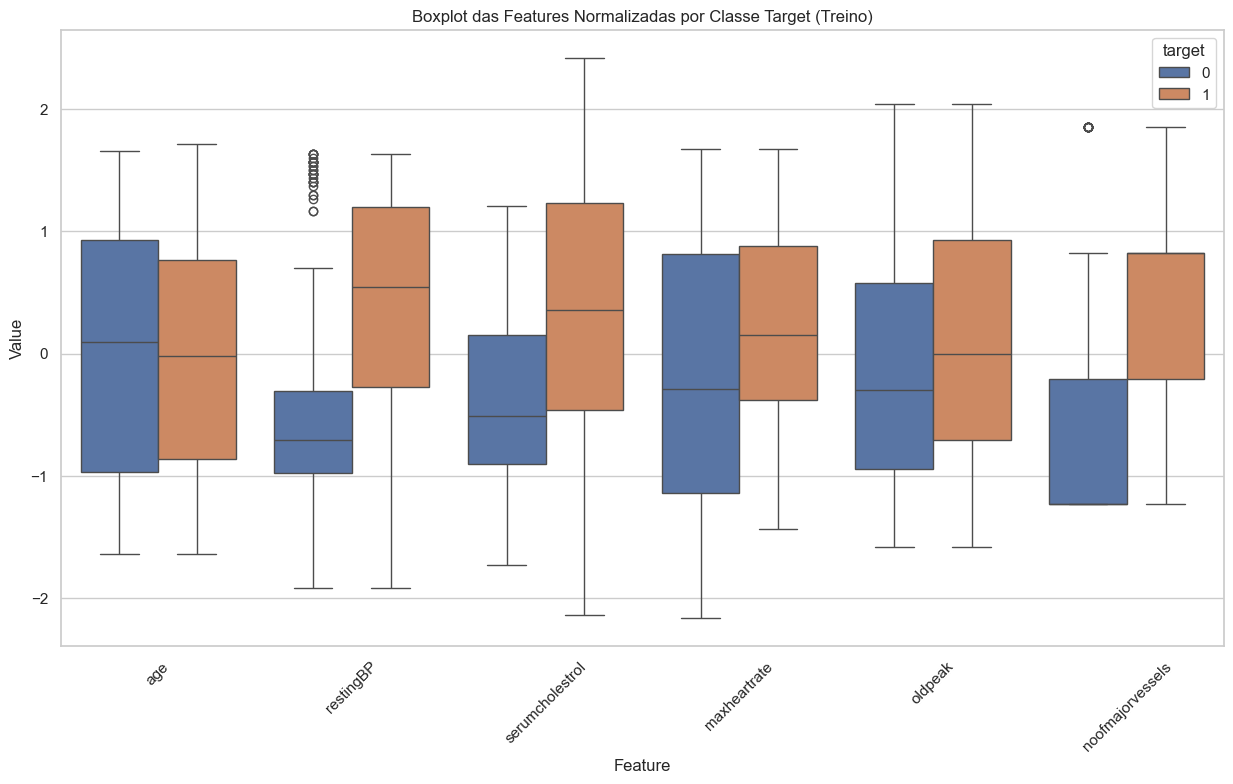

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Criar DataFrame temporário para visualização
train_viz = X_train.copy()
train_viz['target'] = y_train

# Age groups
sns.countplot(data=train_viz, x='age_group', hue='target', ax=axes[0,0])
axes[0,0].set_title('Distribuição por Grupo Etário (Treino)')

# Cholesterol categories
sns.countplot(data=train_viz, x='chol_category', hue='target', ax=axes[0,1])
axes[0,1].set_title('Distribuição por Categoria de Colesterol (Treino)')

# BP categories
sns.countplot(data=train_viz, x='bp_category', hue='target', ax=axes[1,0])
axes[1,0].set_title('Distribuição por Categoria de Pressão Arterial (Treino)')

# BP Age Index
sns.histplot(data=train_viz, x='bp_age_index', hue='target', multiple='stack', ax=axes[1,1])
axes[1,1].set_title('Distribuição do Índice BP × Idade (Treino)')

plt.tight_layout()
plt.show()

# Distribuição das features numéricas normalizadas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features_to_plot = ['age', 'serumcholestrol', 'restingBP', 'maxheartrate', 'cholesterol_age_ratio', 'chronotropic_reserve']

train_scaled_viz = X_train_scaled.copy()
train_scaled_viz['target'] = y_train

for i, feature in enumerate(features_to_plot):
    row = i // 3
    col = i % 3
    sns.histplot(data=train_scaled_viz, x=feature, hue='target', ax=axes[row, col], alpha=0.7)
    axes[row, col].set_title(f'Distribuição Normalizada: {feature} (Treino)')

plt.tight_layout()
plt.show()

# Boxplot das features normalizadas por target
plt.figure(figsize=(15, 8))
df_melted = train_scaled_viz.melt(id_vars=['target'], value_vars=numerical_features_to_scale[:6], var_name='Feature', value_name='Value')
sns.boxplot(data=df_melted, x='Feature', y='Value', hue='target')
plt.title('Boxplot das Features Normalizadas por Classe Target (Treino)')
plt.xticks(rotation=45)
plt.show()

## Salvamento dos Dados Processados

In [8]:
# Salvamento dos dados processados

processed_data_dir = Path('../data/processed')
processed_data_dir.mkdir(parents=True, exist_ok=True)

# Salvar conjuntos de treino e teste separadamente
train_file = processed_data_dir / 'X_train.csv'
test_file = processed_data_dir / 'X_test.csv'
y_train_file = processed_data_dir / 'y_train.csv'
y_test_file = processed_data_dir / 'y_test.csv'

X_train_final.to_csv(train_file, index=False, sep=";")
X_test_final.to_csv(test_file, index=False, sep=";")
y_train.to_csv(y_train_file, index=False, sep=";", header=True)
y_test.to_csv(y_test_file, index=False, sep=";", header=True)

# Salvar scaler (ajustado apenas no treino)
scaler_file = processed_data_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_file)

# Salvar lista de features selecionadas
selected_features_file = processed_data_dir / 'selected_features.pkl'
joblib.dump(selected_features, selected_features_file)

print("Dados processados salvos:")
print(f"- {train_file}")
print(f"- {test_file}")
print(f"- {y_train_file}")
print(f"- {y_test_file}")
print(f"- {scaler_file}")
print(f"- {selected_features_file}")

print(f"\nResumo final:")
print(f"Features selecionadas: {len(selected_features)}")
print(f"Treino: {X_train_final.shape[0]} amostras × {X_train_final.shape[1]} features")
print(f"Teste: {X_test_final.shape[0]} amostras × {X_test_final.shape[1]} features")
print(f"\nScaler treinado apenas com dados de treino ✓")
print(f"Feature selection baseada apenas em dados de treino ✓")

Dados processados salvos:
- ..\data\processed\X_train.csv
- ..\data\processed\X_test.csv
- ..\data\processed\y_train.csv
- ..\data\processed\y_test.csv
- ..\data\processed\scaler.pkl
- ..\data\processed\selected_features.pkl

Resumo final:
Features selecionadas: 13
Treino: 662 amostras × 13 features
Teste: 285 amostras × 13 features

Scaler treinado apenas com dados de treino ✓
Feature selection baseada apenas em dados de treino ✓
